In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

np.random.seed(163)

%run ./DiffusionLunarKF.ipynb
%run ./CentralizedLunarKF.ipynb

In [2]:
C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])

dt = 6
c = 299792458
T_g = 0

iterations = 25

A = np.array([  [1,0,0,0,0,dt,0,0,0,0],
                [0,1,0,0,0,0,dt,0,0,0],
                [0,0,1,0,0,0,0,dt,0,0],
                [0,0,0,1,0,0,0,0,dt,0],
                [0,0,0,0,1,0,0,0,0,dt],
                [0,0,0,0,0,1,0,0,0,0],
                [0,0,0,0,0,0,1,0,0,0],
                [0,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,1,0],
                [0,0,0,0,0,0,0,0,0,1]])

R = lambda N :9*np.eye(2*N,2*N)
Q = np.array([[1.30877395*(10**-12), 4.17228686*(10**-16)],
 [4.17228686*(10**-16), 3.77495000*(10**-16)]])

n = len(C[0])
true_biases = np.array([[np.random.normal(0,10**(-3)) for _ in range(n)]]).T
true_drifts = np.array([[np.random.normal(0,10**(-9)) for _ in range(n)]]).T

def get_station_truth(x,id):
    return np.array([[x[id][0]],[x[n+id][0]]])

x = c*np.vstack((true_biases,true_drifts))

# random initial estimates for each node

x0 = [np.array([[x[i][0]],[x[i+n][0]]]) for i in range(n)]
# x0 = [np.array([[0],[0]]) for _ in range(5)]

P = [np.copy(R(1)) for _ in range(n)]

stations = [Station(i) for i in range(n)]

filter_initialize(stations,D,x0,P)

H_cf = np.array([[1, 0], [1, 0], [0, 1], [0, 1]])
H_20x10 = np.zeros((20, 10))
for i in range(0, 20, 4):
    H_20x10[i:i+4, i//2:i//2+2] = H_cf

# set up process noise covariance matrix Q
Q_10x10 = np.zeros((10, 10))
for i in range(0, 10, 2):
    Q_10x10[i:i+2, i:i+2] = Q

# set up measurement noise covariance matrix R
R_20x20 = np.zeros((20, 20))
for i in range(0, 10):
    R_20x20[i,i] = R(2)[0][0]
for i in range(10,20):
    R_20x20[i,i] = R(2)[1][1]

kf = KalmanFilter(A = A, H = H_20x10, Q = Q_10x10, R = R_20x20, x0 = x)
#For the first iteration these are our cross_links

In [3]:
truth = []
measurements = []
error_bias = np.zeros((iterations,n))

predictions_df = []
errors_df = np.zeros((iterations,n,2,1))
P_hist_df = np.zeros((iterations,n,2,2))

truth = []
predictions_cf = [x]
errors_cf = []
P_hist_cf = []


#Process Noise
procc_noise = lambda : np.linalg.cholesky(Q_10x10) @ np.random.normal(np.array([[0 for _ in range(10)]]).T)
measure_noise = lambda : np.linalg.cholesky(R_20x20)@np.random.normal(np.array([[0 for _ in range(20)]]).T)

x = A@x + procc_noise()
truth.append(x)

T_g += 6
true_biases = [x[:n][i]/c for i in range(n)]
true_drifts = [x[n:][i]/c for i in range(n)]

for i in range(iterations):
    #This is our new truth

    z = (H_20x10 @ truth[-1]) + measure_noise()
    gps_measurements = [np.array([[z[2*k][0],z[2*k+1][0],z[2*(n+k)][0],z[2*(n+k)+1][0]]]).T for k in range(n)]
    measurements.append(z)

    kf.update(z) # Correct estimate using measurement

    predictions_cf.append(kf.x) # Record updated estimate and error
    errors_cf.append(kf.x - truth[-1])

    kf.predict() # Predict next step
    P_hist_cf.append(kf.P) # Append the covariance matrix history


    if i == 0:
        measures,time_ests, cov_ests = diffusion_filter_iteration(stations,Q,R,C,gps_measurements,None,None,true_biases,true_drifts,T_g,dt)
    else:
        measures,time_ests,cov_ests = diffusion_filter_iteration(stations,Q,R,C,gps_measurements,time_ests,cov_ests,true_biases,true_drifts,T_g,dt)
    errors_df[i] = np.array([station.x - get_station_truth(x,station.id) for station in stations])
    predictions_df.append([stn.x for stn in stations])
    P_hist_df[i] = np.array([station.P for station in stations])

    x = A@x + procc_noise()
    truth.append(x)

    T_g += 6
    true_biases = [x[:n][k]/c for k in range(n)]
    true_drifts = [x[n:][k]/c for k in range(n)]

    t_np1 = [new_local_times(T_g,true_biases[k][0],true_drifts[k][0])['n'] for k in range(n)]
    t_n = [stations[k].local_time['n'] for k in range(n)]
    t_bp = [stations[k].local_time['Bp'] for k in range(n)]

    error_bias[i] = np.array([3*(1-((t_bp[k] - t_n[k])/3)/((t_np1[k] - t_n[k])/6)) for k in range(n)])


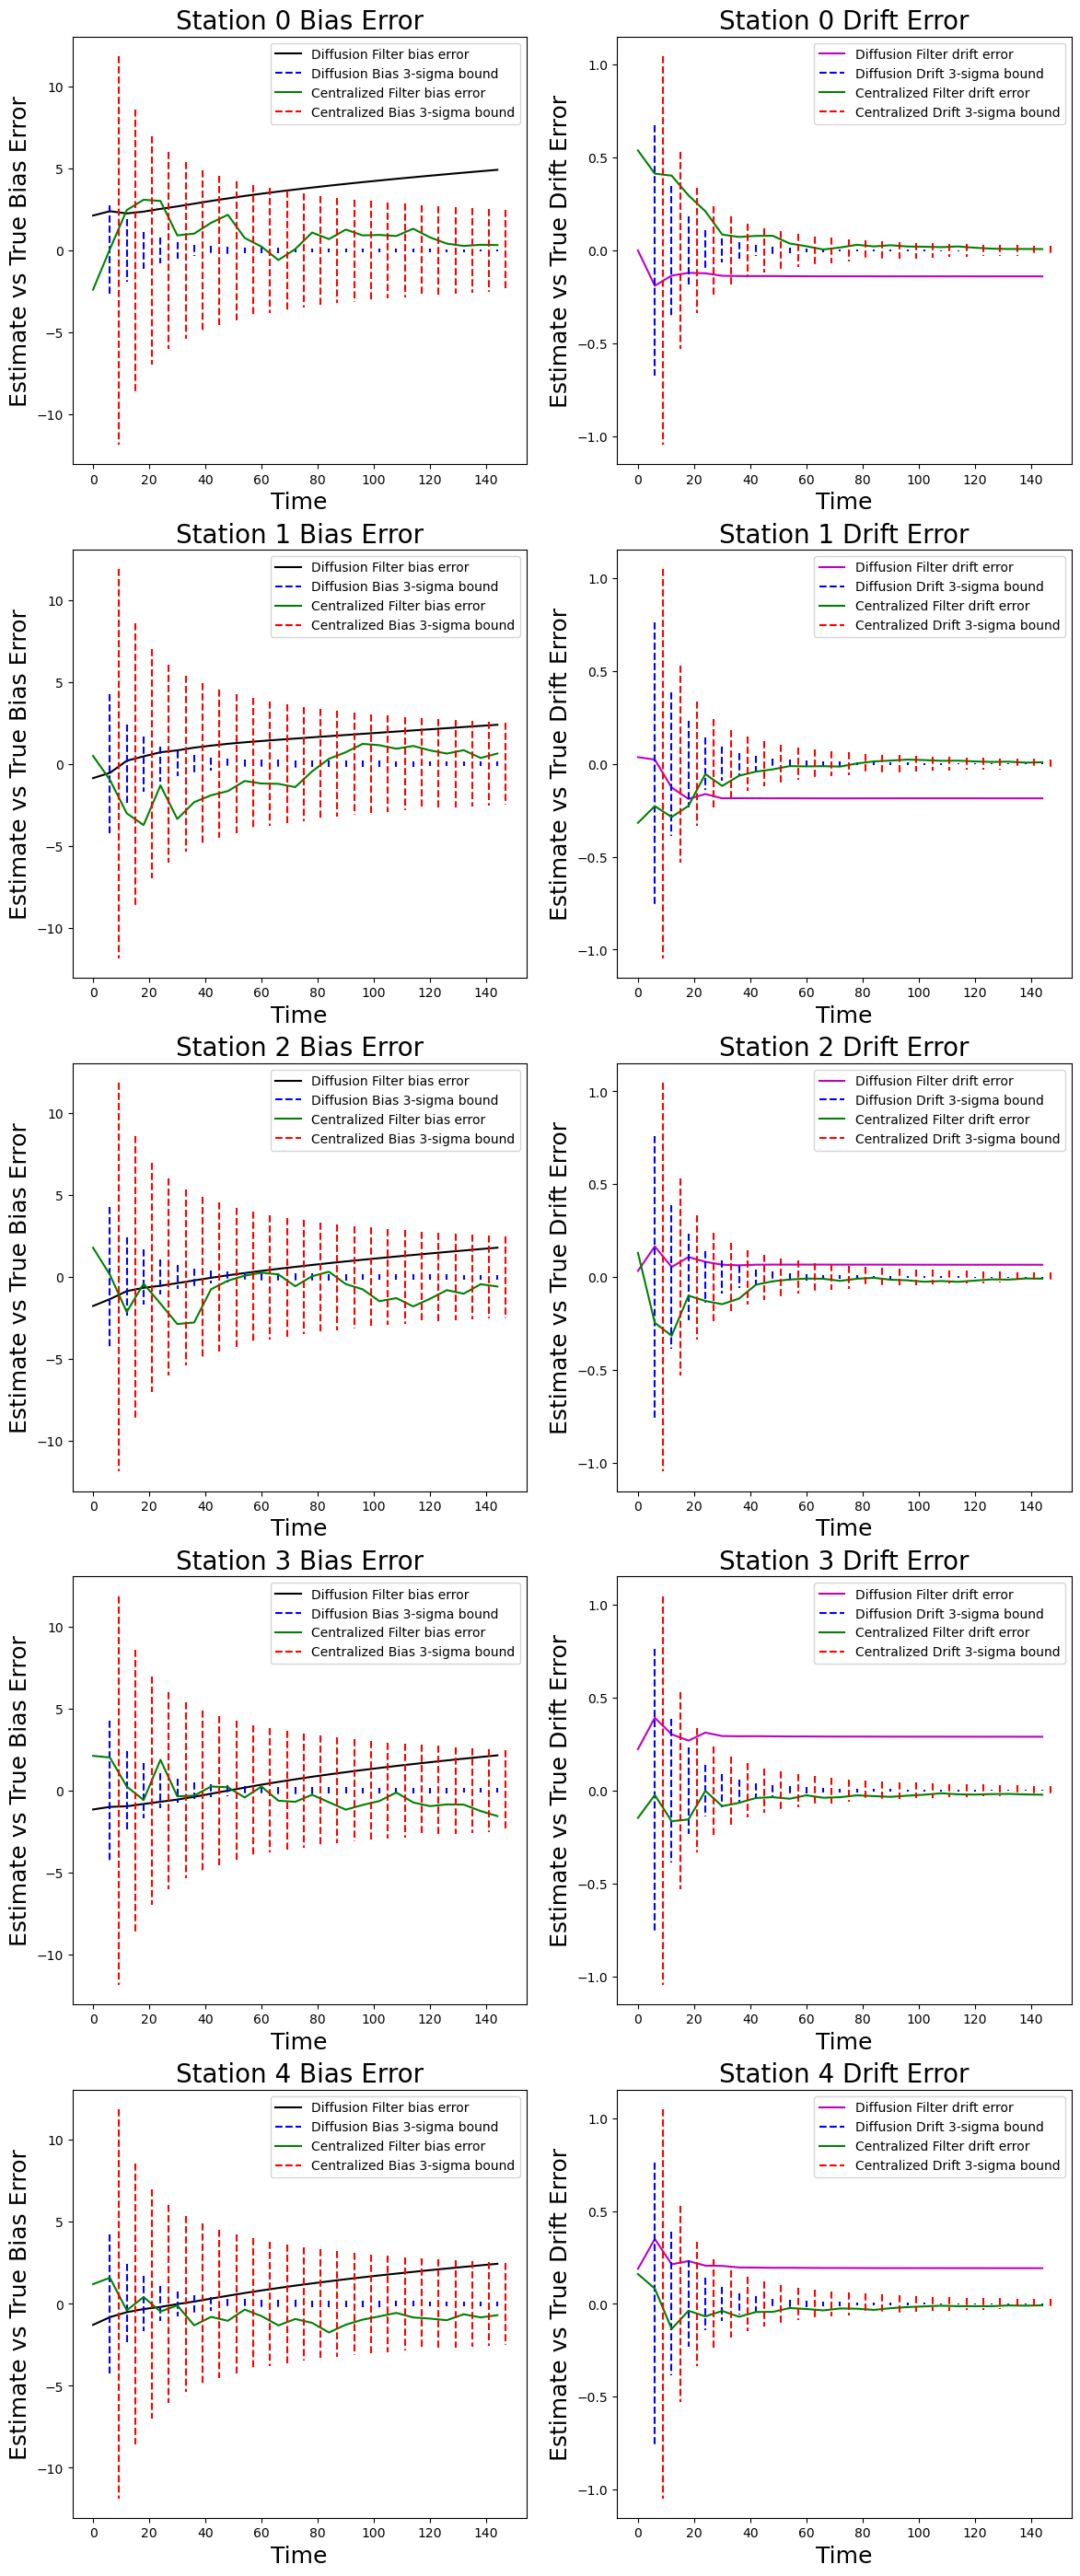

In [5]:
#Number of stations whose plots we are looking at
k = [0,1,2,3,4]

num_rows = len(k)
fig,axs = plt.subplots(num_rows,2, figsize=(14, 7*num_rows))
t_hist = np.arange(0, dt*iterations, dt)
t_hist_cf = np.arange(3, dt*iterations, dt)

errors_cf = np.array(errors_cf).squeeze()
P_hist_cf = np.array(P_hist_cf)

for inx,i in enumerate(k):
    #Diffusion Filter Error Plots
    axs[inx][0].plot(t_hist, errors_df[:, i,0,0], 'k', label = "Diffusion Filter bias error")
    bias_cov = 3*np.sqrt(P_hist_df[:, i,0,0]+error_bias[:,i])
    axs[inx][0].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([bias_cov[1], -bias_cov[1]]), 'b--', label = "Diffusion Bias 3-sigma bound")
    axs[inx][0].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([bias_cov[2:], -bias_cov[2:]]), 'b--')
    error_bias_cf = errors_cf[:, i]
    bias_cov_k = 3*np.sqrt(P_hist_cf[:, i, i])
    axs[inx][0].plot(t_hist, error_bias_cf, label=f'Centralized Filter bias error',color = "green")
    axs[inx][0].plot(np.vstack([t_hist_cf[1], t_hist_cf[1]]), np.vstack([bias_cov_k[1], -bias_cov_k[1]]), 'r--',label = "Centralized Bias 3-sigma bound")
    axs[inx][0].plot(np.vstack([t_hist_cf[2:], t_hist_cf[2:]]), np.vstack([bias_cov_k[2:], -bias_cov_k[2:]]), 'r--')
    axs[inx][0].legend()
    axs[inx][0].set_title("Station "+str(i)+" Bias Error", fontsize = 20)
    axs[inx][0].set_xlabel("Time", fontsize = 18)
    axs[inx][0].set_ylabel("Estimate vs True Bias Error", fontsize = 18)

    axs[inx][1].plot(t_hist, errors_df[:, i,1,0], 'm', label = "Diffusion Filter drift error")
    drift_cov = 3*np.sqrt(P_hist_df[:, i,1,1])
    axs[inx][1].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([drift_cov[1], -drift_cov[1]]), 'b--', label = "Diffusion Drift 3-sigma bound")
    axs[inx][1].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([drift_cov[2:], -drift_cov[2:]]), 'b--')
    error_drift = errors_cf[:, n+i]
    drift_cov_k = 3*np.sqrt(P_hist_cf[:, n+i, n+i])
    axs[inx][1].plot(t_hist, error_drift, label=f'Centralized Filter drift error',color = "green")
    axs[inx][1].plot(np.vstack([t_hist_cf[1], t_hist_cf[1]]), np.vstack([drift_cov_k[1], -drift_cov_k[1]]), 'r--', label = "Centralized Drift 3-sigma bound")
    axs[inx][1].plot(np.vstack([t_hist_cf[2:], t_hist_cf[2:]]), np.vstack([drift_cov_k[2:], -drift_cov_k[2:]]), 'r--')
    axs[inx][1].legend()
    axs[inx][1].set_title("Station "+str(i)+" Drift Error", fontsize = 20)
    axs[inx][1].set_xlabel("Time", fontsize = 18)
    axs[inx][1].set_ylabel("Estimate vs True Drift Error", fontsize = 18)



plt.show()